In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from scipy.stats import zscore
from scipy.stats import skew, kurtosis

from sklearn.decomposition import PCA

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform

import os
import warnings
warnings.filterwarnings('ignore')
import kagglehub


sns.set(style="whitegrid")

In [2]:
def dataset_summary(df, name="Dataset"):
    print(f"====== {name} Summary ======")
    print("Shape:", df.shape)
    print("\nData Types:")
    print(df.dtypes.value_counts())
    print("\nBasic Stats:")
    display(df.describe())
    print("\nNull Check:")
    print(df.isnull().sum().sum(), "missing values")


In [3]:
def evaluate_skew_kurt(df, name):
    numeric_cols = df.select_dtypes(include='number')
    return pd.DataFrame({
        "Dataset": name,
        "Feature": numeric_cols.columns,
        "Skewness": numeric_cols.apply(skew),
        "Kurtosis": numeric_cols.apply(kurtosis)
    }).reset_index(drop=True)

In [4]:
def plot_distributions(df, name="Dataset"):
    import matplotlib.pyplot as plt
    import seaborn as sns

    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    for col in numeric_cols:
        plt.figure(figsize=(6, 3))
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"{name} - Distribution of {col}")
        plt.tight_layout()
        plt.show()


In [5]:
def plot_boxplot(df, title):
    plt.figure(figsize=(16, 6))
    sns.boxplot(data=df, orient='h', palette='Set2')
    plt.title(f'Boxplot of Numeric Features – {title}')
    plt.xlabel("Value Range")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

In [6]:
def plot_categorical_distributions(df, name="Dataset"):
    import matplotlib.pyplot as plt

    categorical_cols = df.select_dtypes(include='object').columns

    for col in categorical_cols:
        plt.figure(figsize=(6, 3))
        df[col].value_counts(normalize=True).plot(kind='bar')
        plt.title(f"{name} - {col} Distribution")
        plt.ylabel("Proportion")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [7]:
def pca_compactness_summary(df_scaled, top_k_components=3):
    pca = PCA()
    pca.fit(df_scaled)

    print("Explained Variance (first 5 components):")
    for i, ratio in enumerate(pca.explained_variance_ratio_[:5]):
        print(f"PC{i+1}: {ratio:.4f}")

    loadings = pd.DataFrame(pca.components_[:top_k_components],
                            columns=df_scaled.columns,
                            index=[f"PC{i+1}" for i in range(top_k_components)])

    # Top contributing features per component
    top_features = {}
    for pc in loadings.index:
        top_features[pc] = loadings.loc[pc].abs().sort_values(ascending=False).head(5).index.tolist()

    return loadings, top_features


In [53]:
def print_top_pca_features(df_scaled, dataset_name="Dataset", top_k=3):
    pca = PCA()
    pca.fit(df_scaled)

    loadings = pd.DataFrame(
        pca.components_[:2],  # PC1 and PC2
        columns=df_scaled.columns,
        index=["PC1", "PC2"]
    )

    print(f"=== Top {top_k} Feature Contributions – {dataset_name} ===")
    for pc in loadings.index:
        top_features = loadings.loc[pc].abs().sort_values(ascending=False).head(top_k)
        print(f"\n{pc}:")
        for feature, weight in top_features.items():
            print(f"  {feature}: {weight:.4f}")


In [8]:
def plot_pca_heatmap(df_scaled, dataset_name="Dataset", top_k_components=5):
    pca = PCA()
    pca.fit(df_scaled)

    loadings = pd.DataFrame(
        pca.components_[:top_k_components],
        columns=df_scaled.columns,
        index=[f"PC{i+1}" for i in range(top_k_components)]
    )

    plt.figure(figsize=(12, 6))
    sns.heatmap(loadings, cmap="coolwarm", center=0)
    plt.title(f"{dataset_name} – PCA Loadings (Top {top_k_components} PCs)")
    plt.tight_layout()
    plt.show()


In [9]:
def explained_variance_plot(df_scaled, name="Dataset"):
    pca = PCA()
    pca.fit(df_scaled)

    plt.figure(figsize=(6, 3))
    plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
             pca.explained_variance_ratio_.cumsum(), marker='o')
    plt.title(f"{name} - Cumulative Explained Variance")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [10]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def hopkins(X):
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.neighbors import NearestNeighbors
    import numpy as np
    from random import sample
    from numpy.random import uniform
    from math import isnan

    X = MinMaxScaler().fit_transform(X)
    d = X.shape[1]
    n = len(X)
    m = int(0.1 * n)

    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    rand_X = sample(range(0, n), m)

    ujd = []
    wjd = []

    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors([uniform(0, 1, d)], 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors([X[rand_X[j]]], 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    return round(H, 4)


In [11]:
from scipy.stats import zscore
import numpy as np
import pandas as pd

def detect_zscore_outliers(df, threshold=3.0):
    z_scores = np.abs(zscore(df))
    outliers = (z_scores > threshold)

    outlier_counts = pd.DataFrame({
        'Feature': df.columns,
        'Outlier_Count': outliers.sum(axis=0),
        'Outlier_%': 100 * outliers.sum(axis=0) / df.shape[0]
    })

    return outlier_counts.sort_values(by='Outlier_%', ascending=False).reset_index(drop=True)


In [12]:

def pca_projection(df_scaled, name="Dataset"):

    pca = PCA(n_components=2)
    components = pca.fit_transform(df_scaled)

    plt.figure(figsize=(6, 4))
    plt.scatter(components[:, 0], components[:, 1], alpha=0.5)
    plt.title(f"{name} - PCA Projection (2D)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()


In [13]:
student_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"

import zipfile, io, requests

r = requests.get(student_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("student_data")

df_student = pd.read_csv("student_data/student-mat.csv", sep=";")
print(" Loaded Student Performance:", df_student.shape)


 Loaded Student Performance: (395, 33)


In [14]:
wine_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

df_wine = pd.read_csv(wine_url, sep=";")
print(" Loaded Wine Quality (Red):", df_wine.shape)


 Loaded Wine Quality (Red): (1599, 12)


In [15]:
path = kagglehub.dataset_download("hrhuynguyen/2d-spatial-dataset")

print("Path to dataset files:", path)

complex8_path = os.path.join(path, "Complex8.csv")

df_complex8 = pd.read_csv(complex8_path, header=None) 
df_complex8.columns = ['x', 'y', 'label']            

print(df_complex8.head())


Path to dataset files: /home/wjoei/.cache/kagglehub/datasets/hrhuynguyen/2d-spatial-dataset/versions/1
         x       y  label
0  564.887  58.119      0
1  565.434  68.061      0
2  565.926  79.953      0
3  566.762  69.405      0
4  567.990  81.669      0


In [16]:
print(df_complex8.head())
df_complex8.describe()
df_complex8.info()

         x       y  label
0  564.887  58.119      0
1  565.434  68.061      0
2  565.926  79.953      0
3  566.762  69.405      0
4  567.990  81.669      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       2550 non-null   float64
 1   y       2550 non-null   float64
 2   label   2550 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 59.9 KB


In [17]:
print("Student Performance Dataset")
print("Shape:", df_student.shape)
display(df_student.head())
display(df_student.describe())
df_student.info()


Student Performance Dataset
Shape: (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [18]:
print("Wine Quality (Red) Dataset")
print("Shape:", df_wine.shape)
display(df_wine.head())
display(df_wine.describe())
df_wine.info()


Wine Quality (Red) Dataset
Shape: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [19]:
# Student
print("Student Performance Duplicates:", df_student.duplicated().sum())

# Wine
print("Wine Quality Duplicates:", df_wine.duplicated().sum())

# Spatial
print("2d Spatial Duplicates:", df_complex8.duplicated().sum())

Student Performance Duplicates: 0
Wine Quality Duplicates: 240
2d Spatial Duplicates: 0


In [20]:
print(df_student.dtypes)
print(df_wine.dtypes)
print(df_complex8.dtypes)


school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
dtype: object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulph

In [21]:
# For all datasets
print("Student Unique Value Counts")
print(df_student.nunique())

print("Wine Unique Value Counts")
print(df_wine.nunique())

print ("Spatial Unique Value Counts")
print(df_complex8.nunique())


Student Unique Value Counts
school         2
sex            2
age            8
address        2
famsize        2
Pstatus        2
Medu           5
Fedu           5
Mjob           5
Fjob           5
reason         4
guardian       3
traveltime     4
studytime      4
failures       4
schoolsup      2
famsup         2
paid           2
activities     2
nursery        2
higher         2
internet       2
romantic       2
famrel         5
freetime       5
goout          5
Dalc           5
Walc           5
health         5
absences      34
G1            17
G2            17
G3            18
dtype: int64
Wine Unique Value Counts
fixed acidity            96
volatile acidity        143
citric acid              80
residual sugar           91
chlorides               153
free sulfur dioxide      60
total sulfur dioxide    144
density                 436
pH                       89
sulphates                96
alcohol                  65
quality                   6
dtype: int64
Spatial Unique Value Cou

In [22]:
# Remove duplicates
df_student.drop_duplicates(inplace=True)



In [23]:
# Student categorical data
print("Student object columns:", df_student.select_dtypes(include='object').columns.tolist())

# Wine categorical data
print("Wine object columns:", df_wine.select_dtypes(include='object').columns.tolist())

# Spatial categorical data
print("Sptial object columns:", df_complex8.select_dtypes(include='object').columns.tolist())


Student object columns: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
Wine object columns: []
Sptial object columns: []


In [24]:
# Select only final grade G3 due to high correlation
df_student = df_student.drop(columns=['G1', 'G2'], errors='ignore')


# Drop quality label to ensure unsupervised clustering
df_wine = df_wine.drop(columns=['quality'], errors='ignore')

#No label dropped for spatial dataset

In [25]:
# Encoding of student data
df_student_encoded = pd.get_dummies(df_student, drop_first=True)


In [26]:
print("Student Encoded Shape:", df_student_encoded.shape)

Student Encoded Shape: (395, 40)


In [27]:
# Compute correlation matrices before scaling to not distort the value
corr_student = df_student_encoded.corr()
corr_wine = df_wine.corr() 
corr_complex8=df_complex8.corr()

In [28]:
df_wine.nunique()

fixed acidity            96
volatile acidity        143
citric acid              80
residual sugar           91
chlorides               153
free sulfur dioxide      60
total sulfur dioxide    144
density                 436
pH                       89
sulphates                96
alcohol                  65
dtype: int64

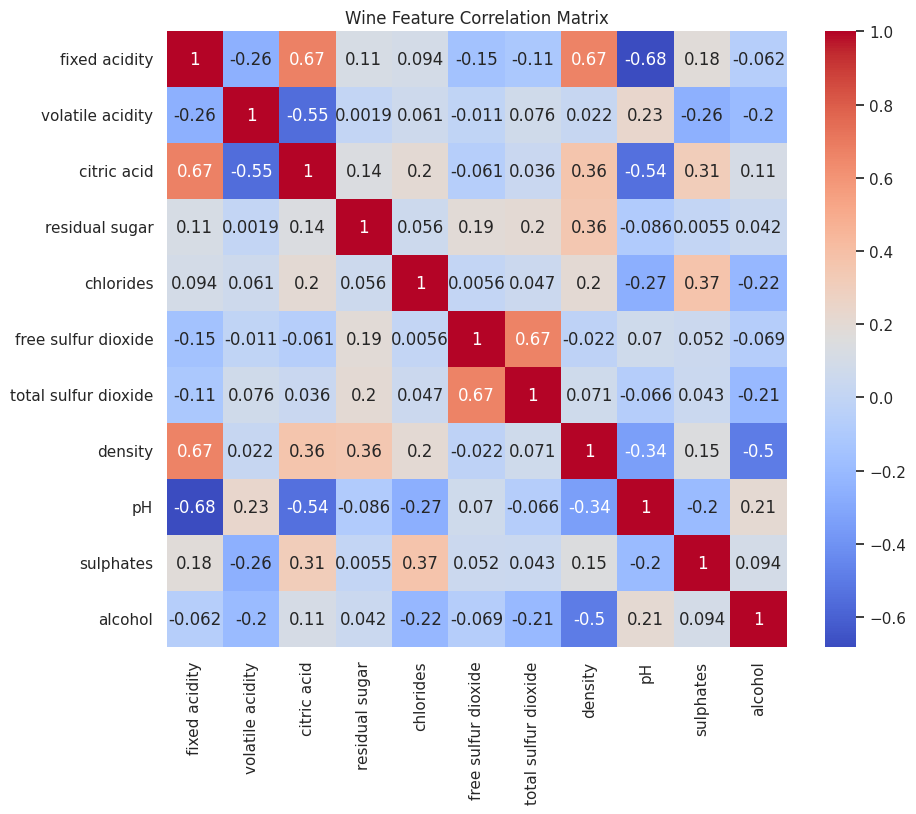

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_wine.corr(), cmap='coolwarm', annot=True)
plt.title("Wine Feature Correlation Matrix")
plt.show()


In [30]:
# Student data scaling
scaler_student = StandardScaler()
X_student = scaler_student.fit_transform(df_student_encoded)

# Wine data scaling
scaler_wine = StandardScaler()
X_wine = scaler_wine.fit_transform(df_wine)

# Spatial data scaling
scaler_spatial=StandardScaler()
X_complex8= scaler_spatial.fit_transform(df_complex8)


In [31]:
# scaled dataframes ; can be used for clustering task 
df_student_scaled = pd.DataFrame(X_student, columns=df_student_encoded.columns)
df_wine_scaled = pd.DataFrame(X_wine, columns=df_wine.columns)
df_complex8_scaled= pd.DataFrame(X_complex8, columns=df_complex8.columns)


In [32]:
dataset_summary(df_student_encoded, "Student")

dataset_summary(df_wine_scaled, "Wine")

dataset_summary(df_complex8_scaled, "Spatial")

====== Student Summary ======
Shape: (395, 40)

Data Types:
bool     26
int64    14
Name: count, dtype: int64

Basic Stats:


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,20.000000



Null Check:
0 missing values
====== Wine Summary ======
Shape: (1599, 11)

Data Types:
float64    11
Name: count, dtype: int64

Basic Stats:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03
mean,3.554936e-16,1.733031e-16,-8.887339e-17,-1.244227e-16,3.732682e-16,-6.221137e-17,4.443669e-17,-3.473172e-14,2.861723e-15,6.754377e-16,1.066481e-16
std,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00
min,-2.137045e+00,-2.278280e+00,-1.391472e+00,-1.162696e+00,-1.603945e+00,-1.422500e+00,-1.230584e+00,-3.538731e+00,-3.700401e+00,-1.936507e+00,-1.898919e+00
25%,-7.007187e-01,-7.699311e-01,-9.293181e-01,-4.532184e-01,-3.712290e-01,-8.487156e-01,-7.440403e-01,-6.077557e-01,-6.551405e-01,-6.382196e-01,-8.663789e-01
50%,-2.410944e-01,-4.368911e-02,-5.636026e-02,-2.403750e-01,-1.799455e-01,-1.793002e-01,-2.574968e-01,1.760083e-03,-7.212705e-03,-2.251281e-01,-2.093081e-01
75%,5.057952e-01,6.266881e-01,7.652471e-01,4.341614e-02,5.384542e-02,4.901152e-01,4.723184e-01,5.768249e-01,5.759223e-01,4.240158e-01,6.354971e-01
max,4.355149e+00,5.877976e+00,3.743574e+00,9.195681e+00,1.112703e+01,5.367284e+00,7.375154e+00,3.680055e+00,4.528282e+00,7.918677e+00,4.202453e+00



Null Check:
0 missing values
====== Spatial Summary ======
Shape: (2550, 3)

Data Types:
float64    3
Name: count, dtype: int64

Basic Stats:


,x,y,label
count,2.550000e+03,2.550000e+03,2.550000e+03
mean,4.458307e-17,-3.343731e-16,-8.916615e-17
std,1.000196e+00,1.000196e+00,1.000196e+00
min,-1.685117e+00,-1.611079e+00,-2.151695e+00
25%,-8.503257e-01,-9.435096e-01,-6.521534e-01
50%,-7.754791e-02,1.445596e-01,3.475407e-01
75%,7.675555e-01,8.100116e-01,8.473878e-01
max,1.880778e+00,1.769594e+00,1.347235e+00



Null Check:
0 missing values


In [33]:
res_student = evaluate_skew_kurt(df_student, "Student")
res_wine = evaluate_skew_kurt(df_wine, "Wine")
res_complex = evaluate_skew_kurt(df_complex8, "Complex8")
all_stats = pd.concat([res_student, res_wine, res_complex], ignore_index=True)


print(all_stats.sort_values(by="Skewness", key=lambda x: x.abs(), ascending=False))

     Dataset               Feature  Skewness   Kurtosis
18      Wine             chlorides  5.675017  41.581708
17      Wine        residual sugar  4.536395  28.524438
12   Student              absences  3.657622  21.430045
23      Wine             sulphates  2.426393  11.679884
5    Student              failures  2.377951   4.926448
9    Student                  Dalc  2.182434   4.684307
3    Student            traveltime  1.600920   2.299470
20      Wine  total sulfur dioxide  1.514109   3.794172
19      Wine   free sulfur dioxide  1.249394   2.013490
14      Wine         fixed acidity  0.981829   1.124856
6    Student                famrel -0.948263   1.110244
24      Wine               alcohol  0.860021   0.195654
13   Student                    G3 -0.729887   0.383181
15      Wine      volatile acidity  0.670962   1.217963
4    Student             studytime  0.629739  -0.029401
10   Student                  Walc  0.609634  -0.796021
11   Student                health -0.492723  -1

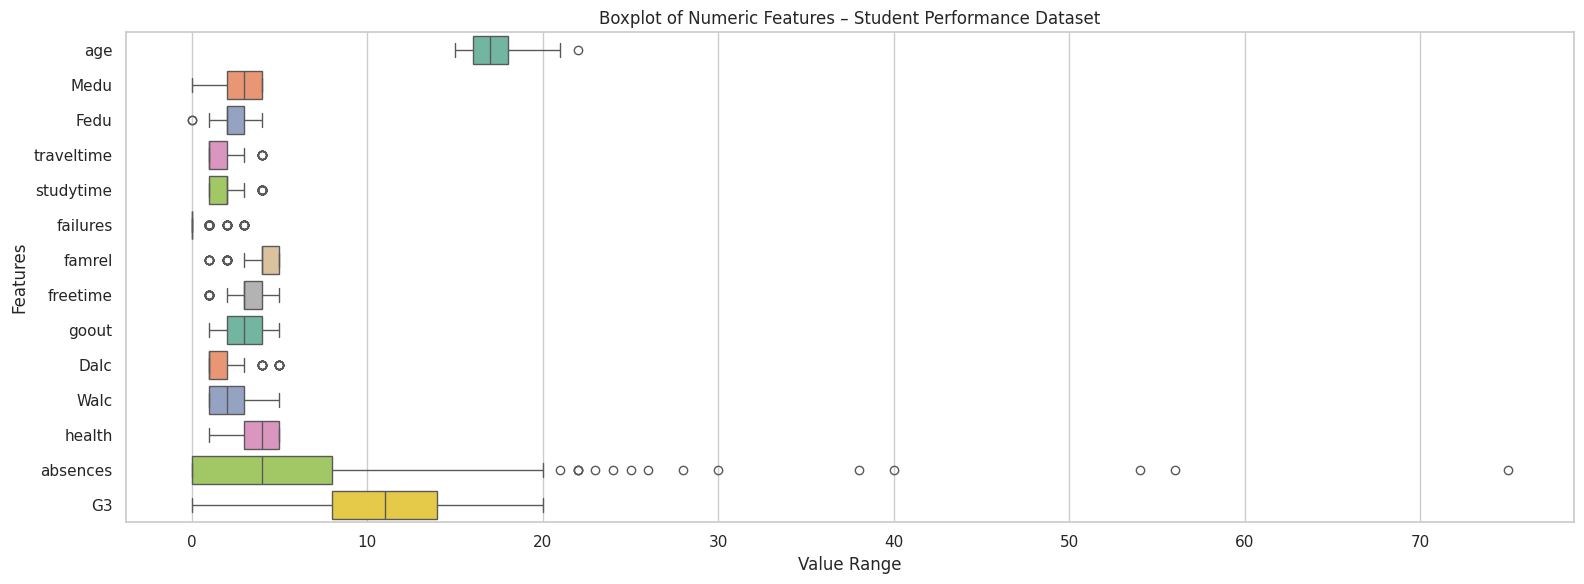

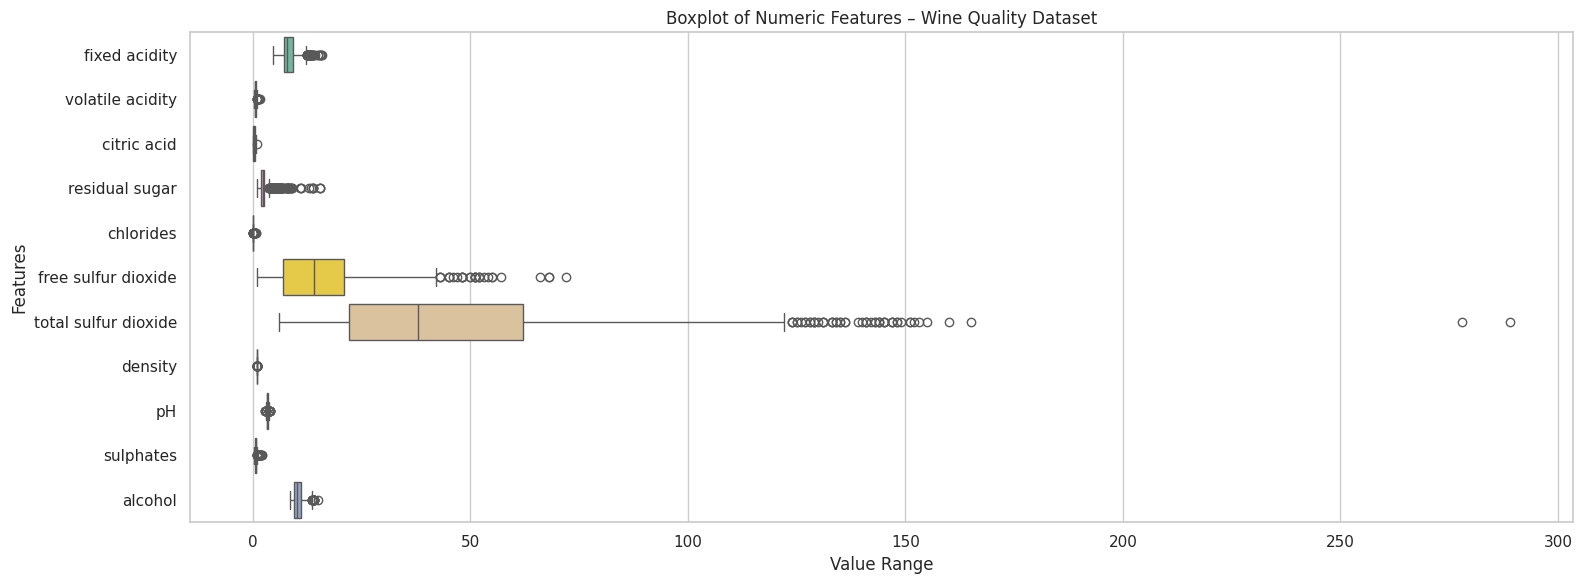

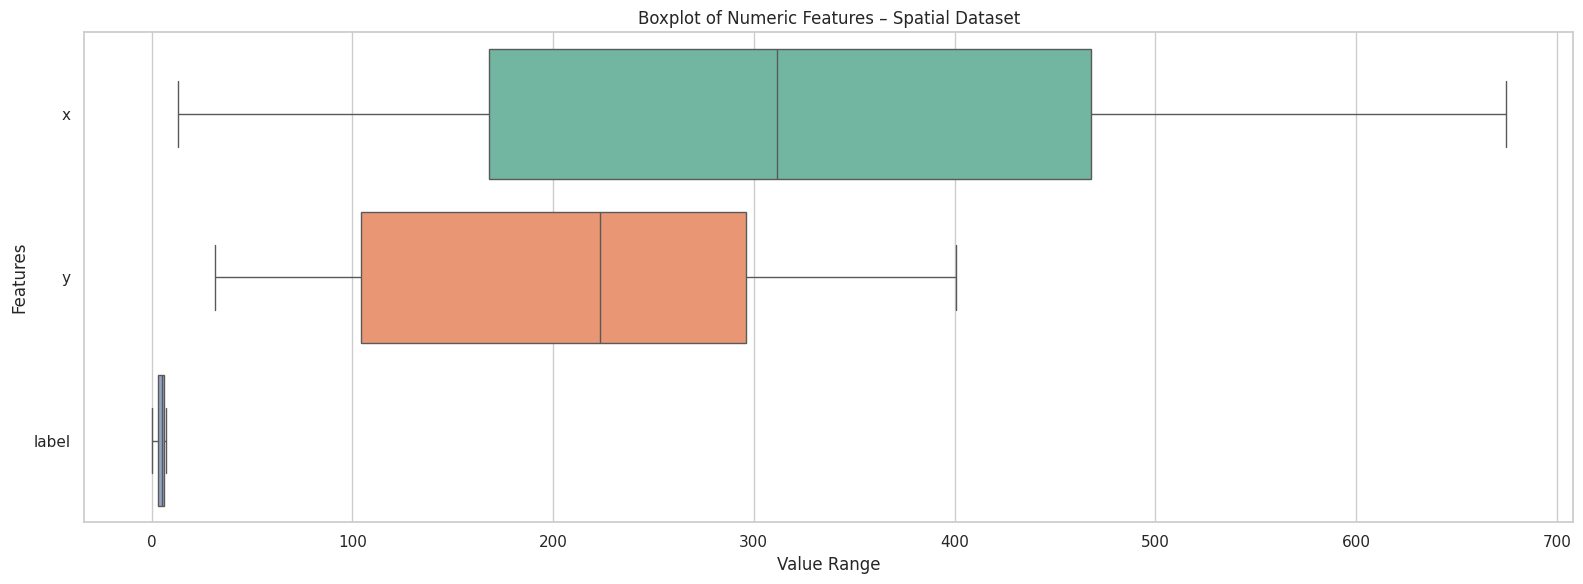

In [34]:
#boxplot
numeric_df_student = df_student.select_dtypes(include=['int64', 'float64'])
numeric_df_wine= df_wine.select_dtypes(include=['int64', 'float64'])
numeric_df_spatial= df_complex8.select_dtypes(include=['int64', 'float64'])

plot_boxplot(numeric_df_student, 'Student Performance Dataset')
plot_boxplot(numeric_df_wine, 'Wine Quality Dataset')
plot_boxplot(numeric_df_spatial, 'Spatial Dataset')

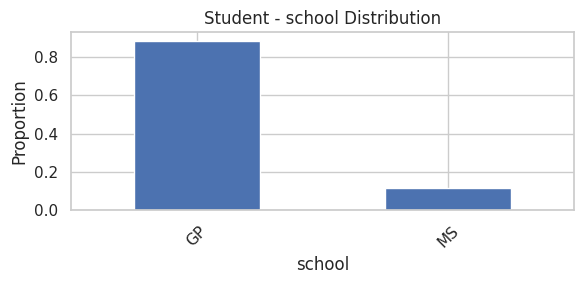

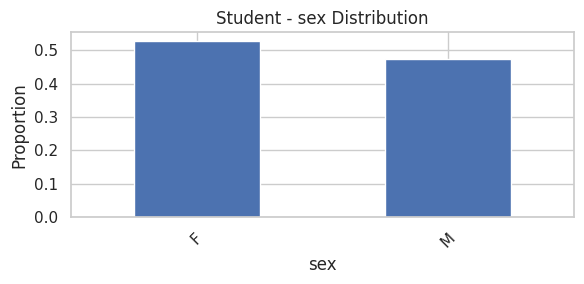

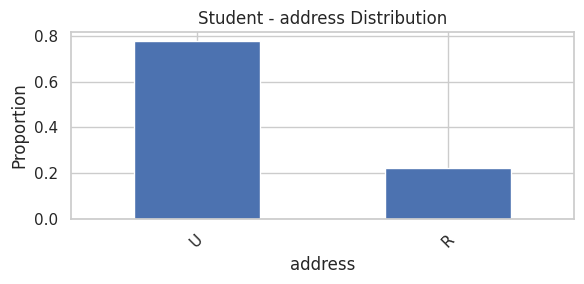

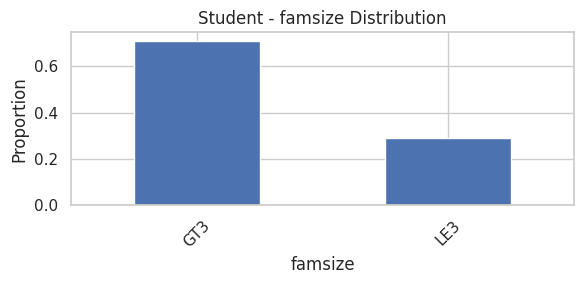

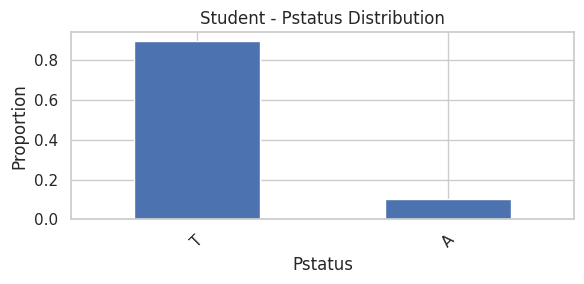

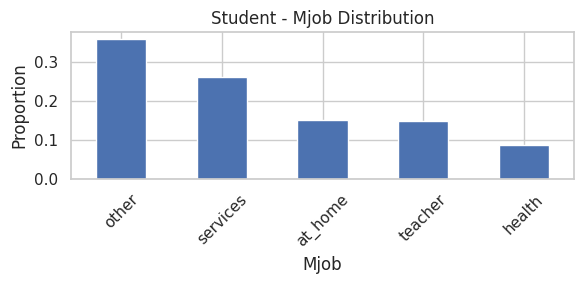

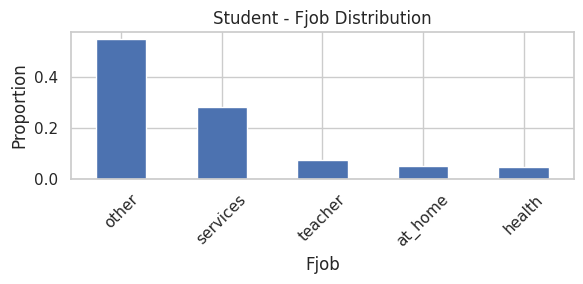

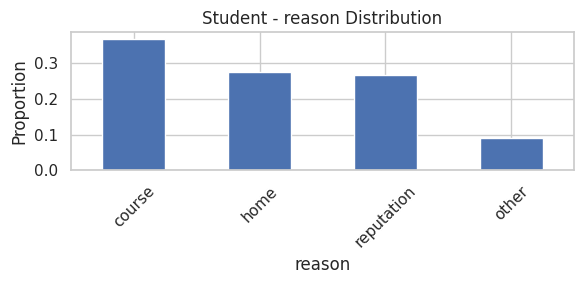

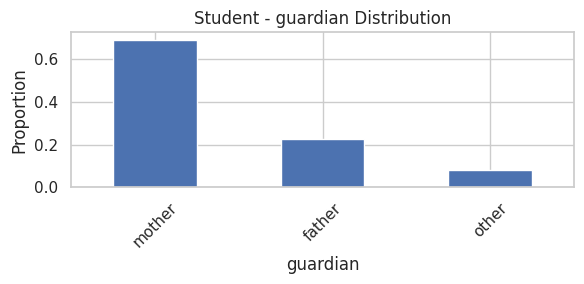

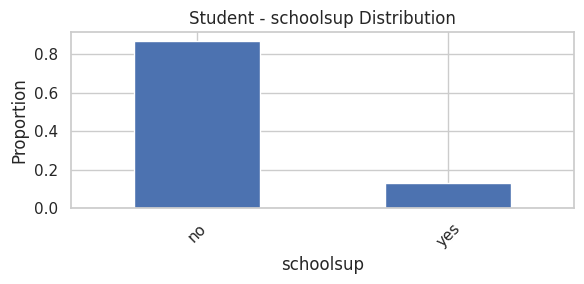

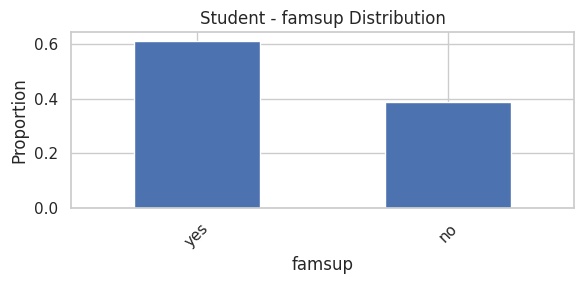

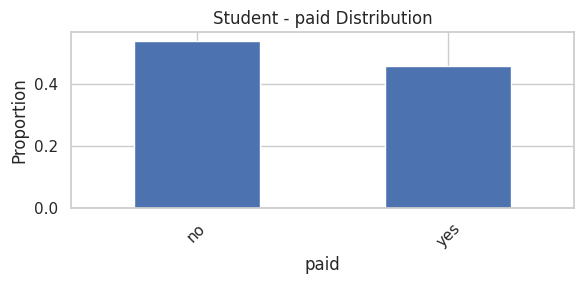

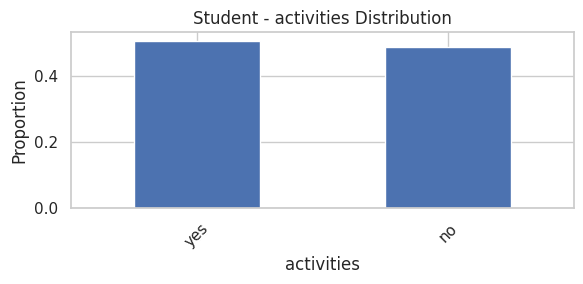

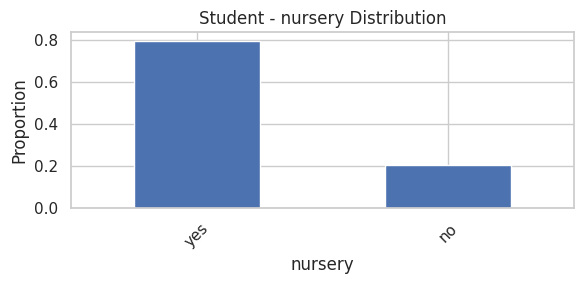

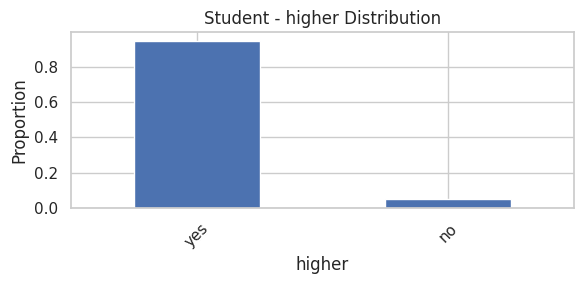

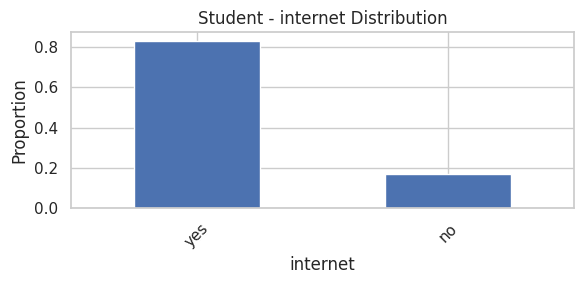

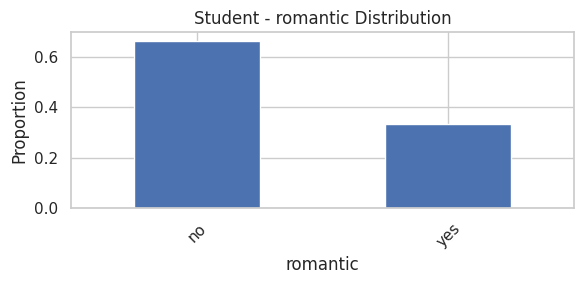

In [35]:
plot_categorical_distributions(df_student, "Student")


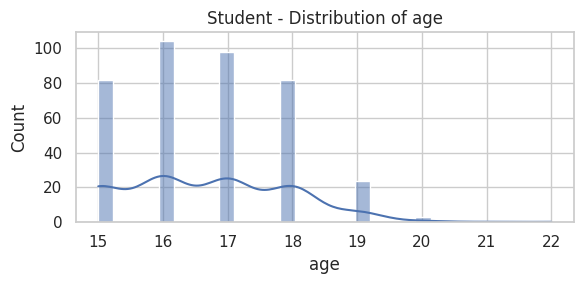

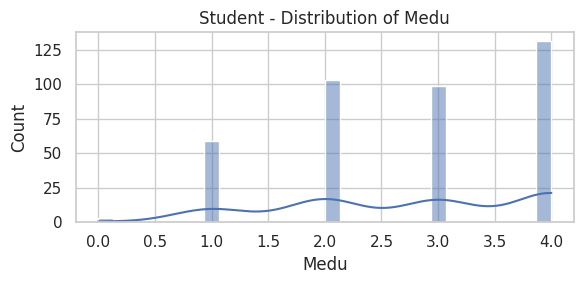

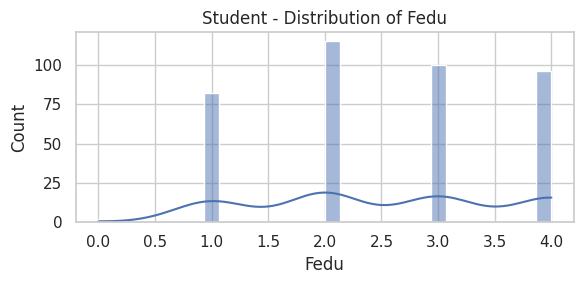

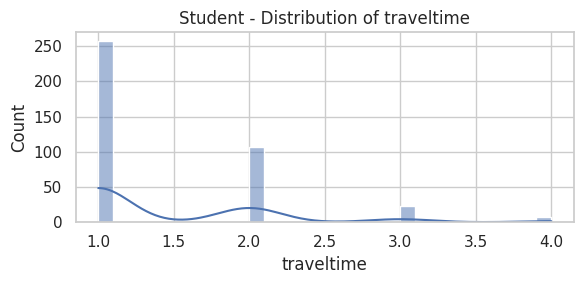

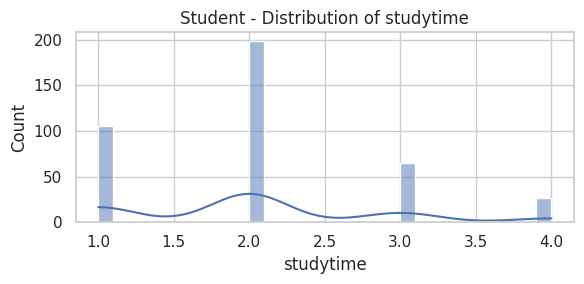

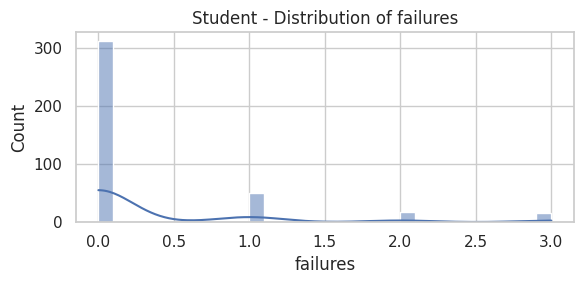

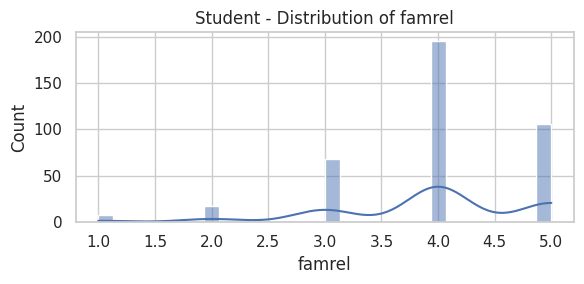

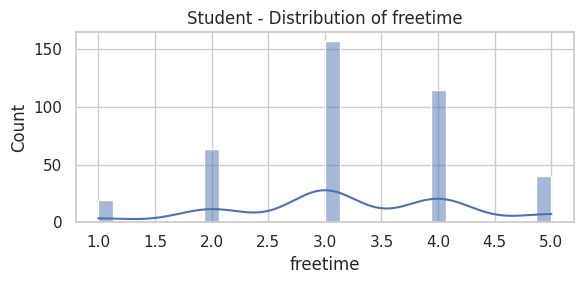

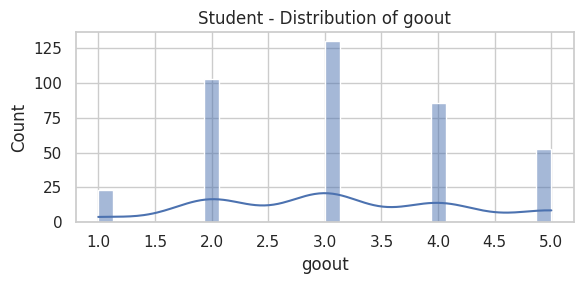

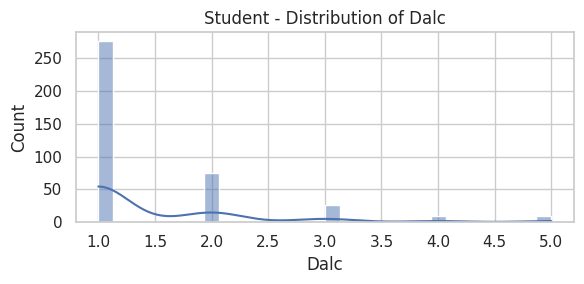

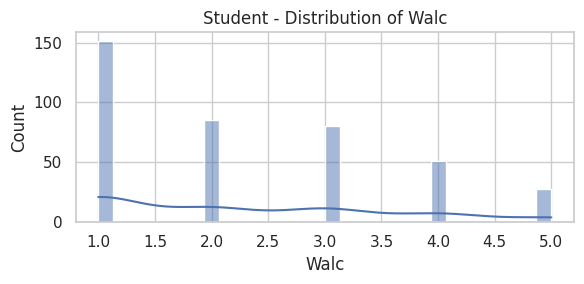

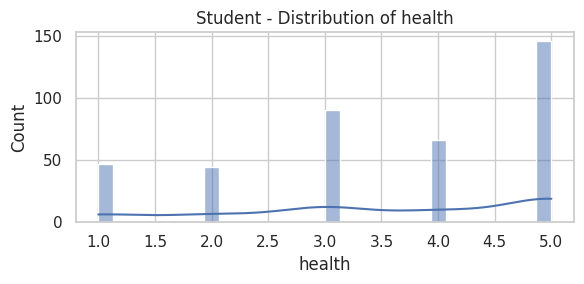

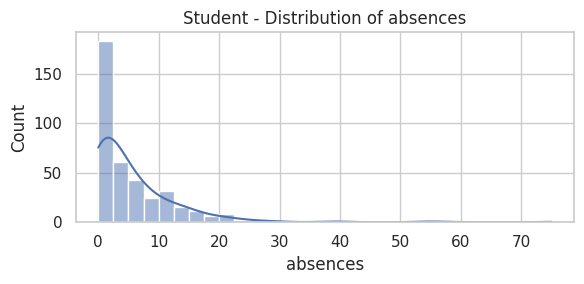

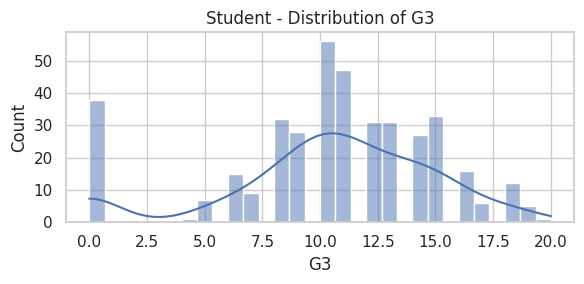

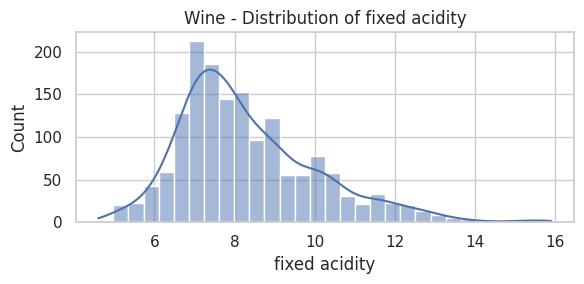

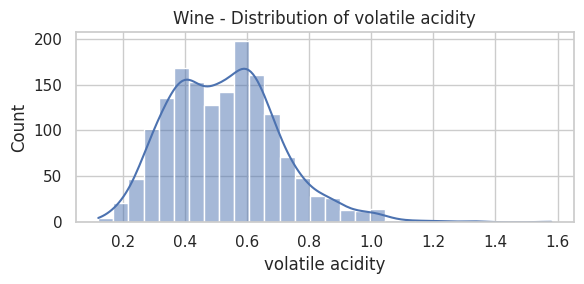

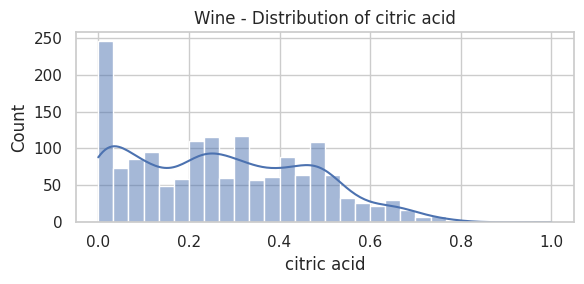

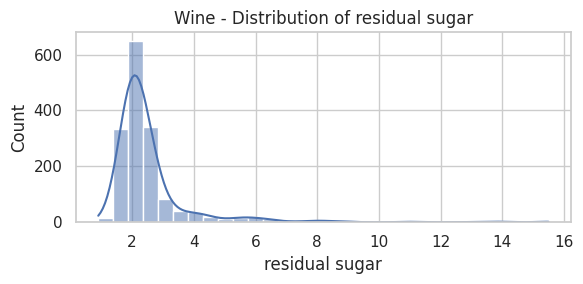

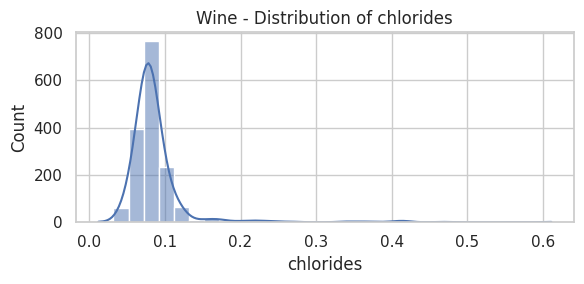

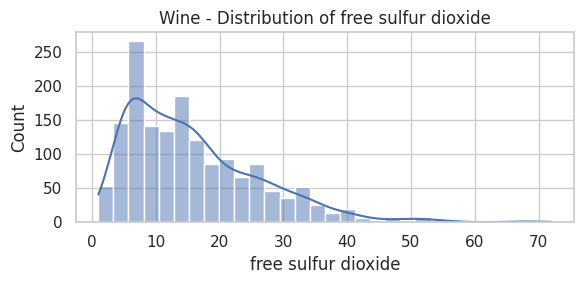

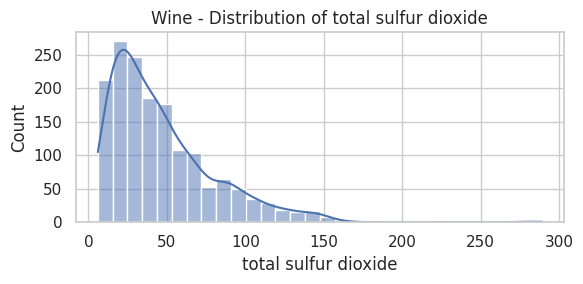

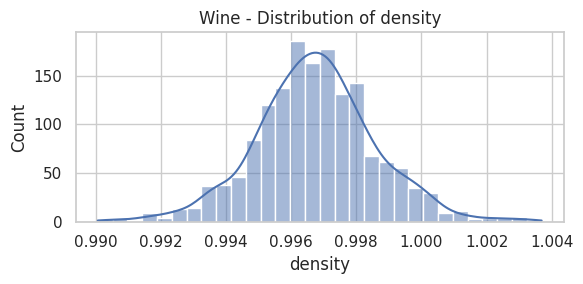

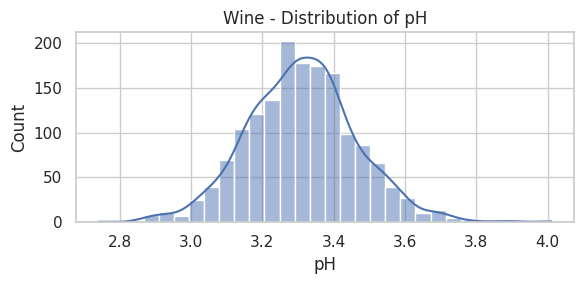

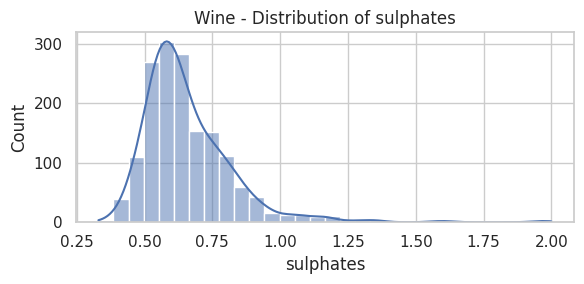

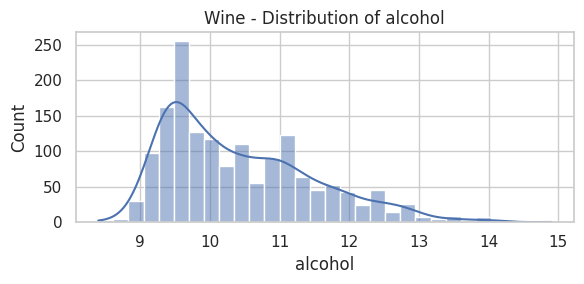

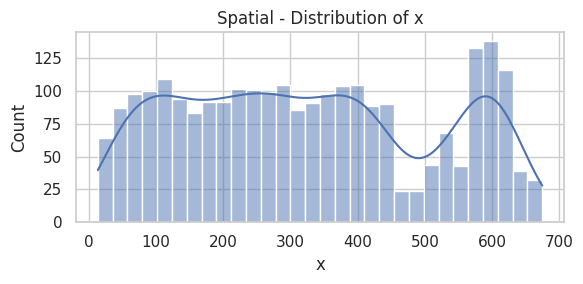

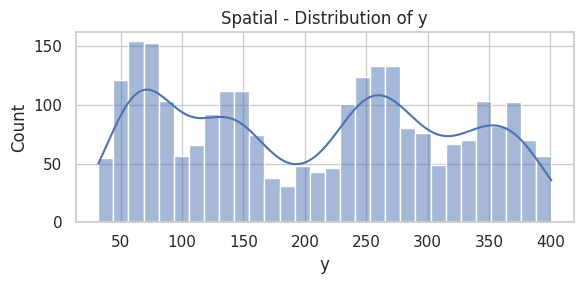

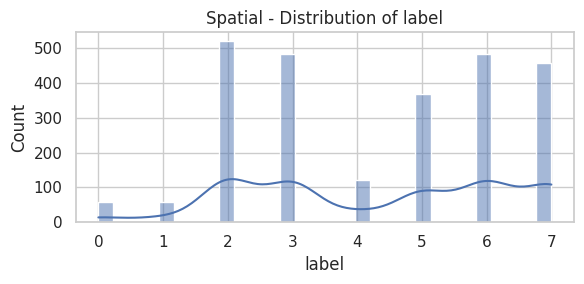

In [36]:
plot_distributions(df_student_encoded, "Student")

plot_distributions(df_wine, "Wine")


plot_distributions(df_complex8, "Spatial")


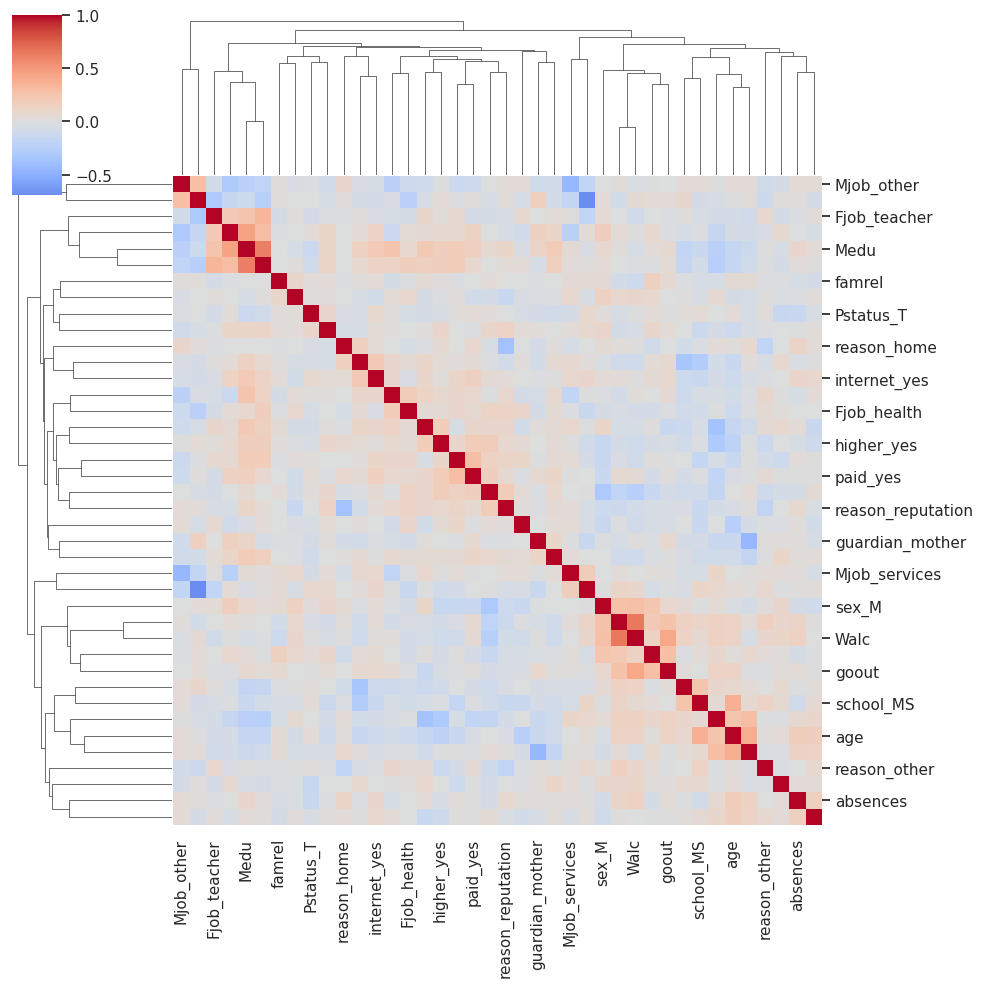

In [37]:
sns.clustermap(corr_student, cmap='coolwarm', center=0)




<Axes: >

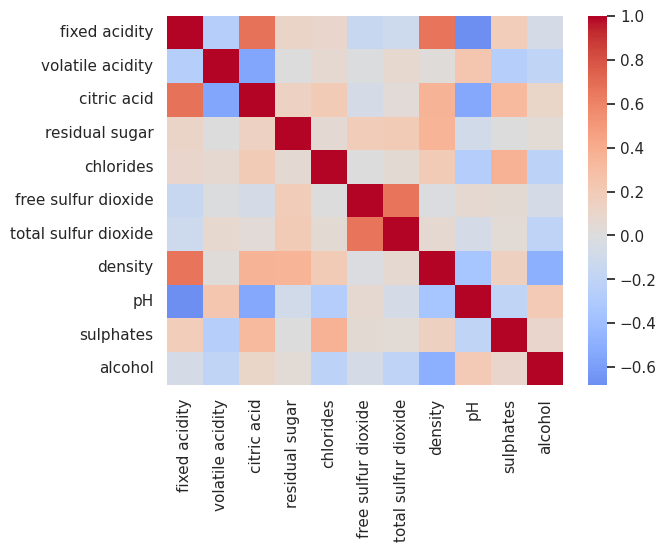

In [38]:
sns.heatmap(corr_wine, cmap='coolwarm', center=0)

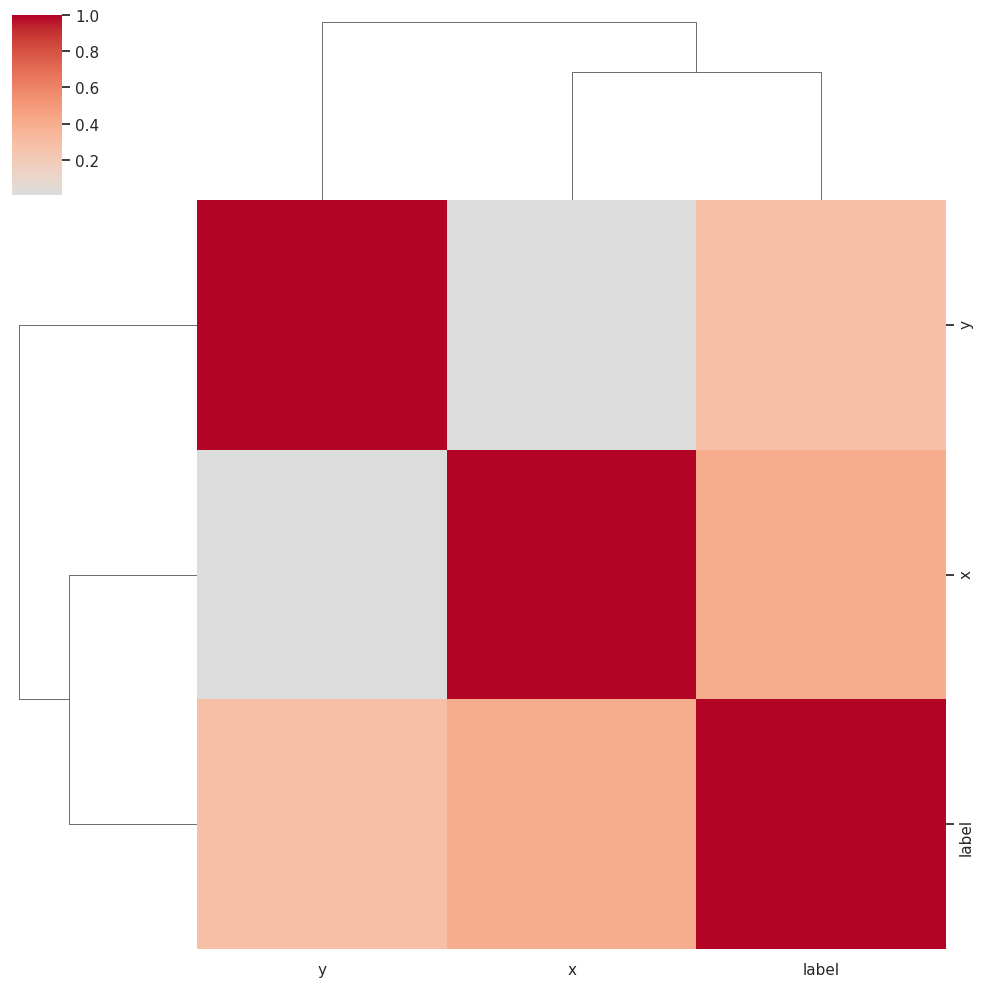

In [39]:
sns.clustermap(corr_complex8, cmap='coolwarm', center=0)


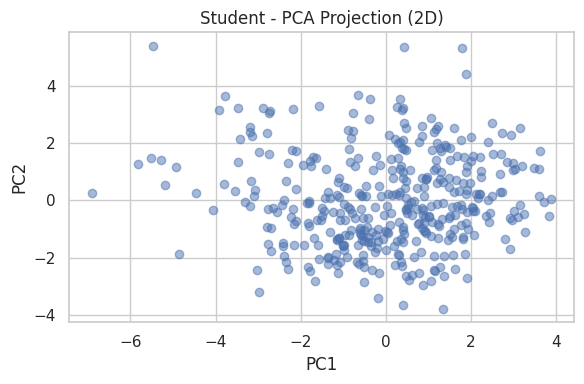

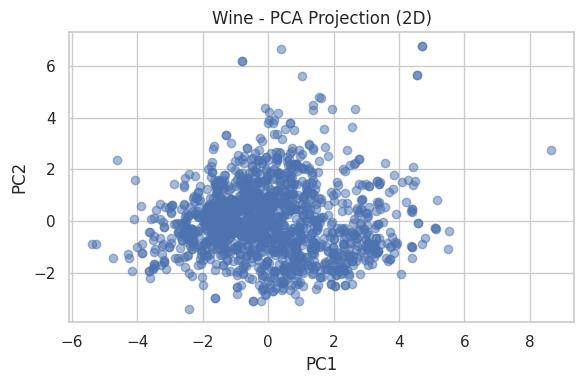

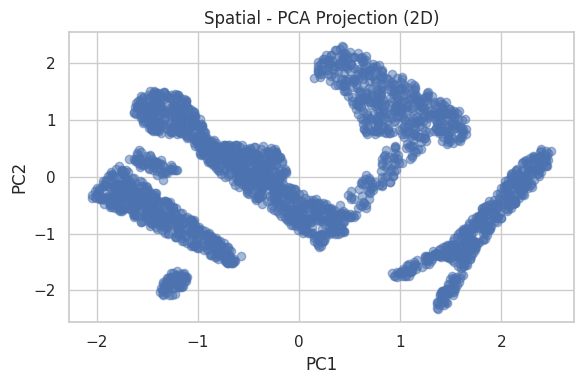

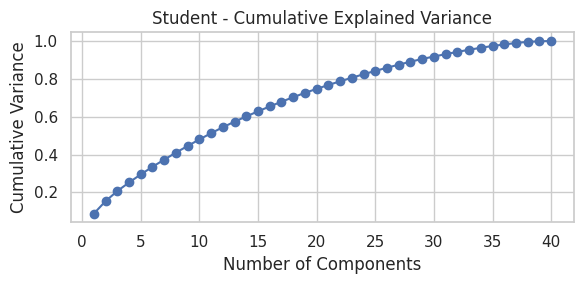

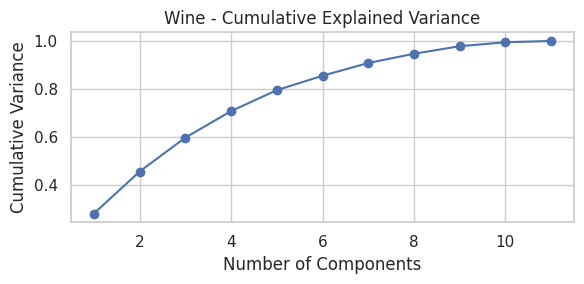

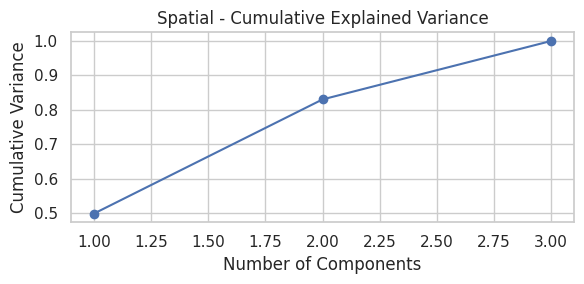

In [40]:
pca_projection(df_student_scaled, "Student")
pca_projection(df_wine_scaled, "Wine")
pca_projection(df_complex8_scaled, "Spatial")


explained_variance_plot(df_student_scaled, "Student")
explained_variance_plot(df_wine_scaled, "Wine")
explained_variance_plot(df_complex8_scaled, "Spatial")

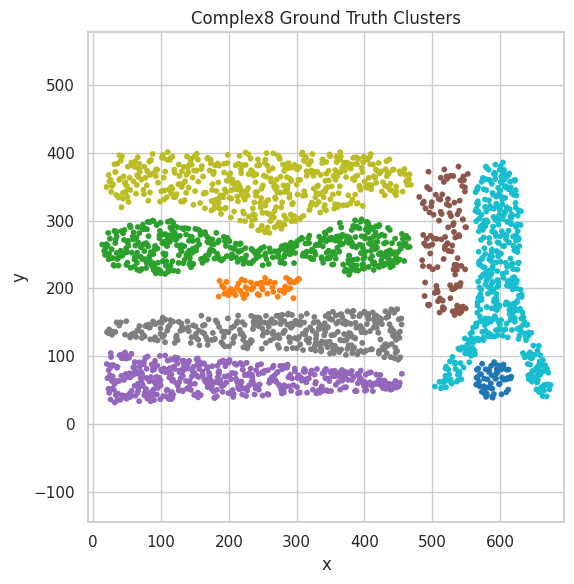

In [41]:
plt.figure(figsize=(6, 6))
plt.scatter(df_complex8['x'], df_complex8['y'], c=df_complex8['label'], cmap='tab10', s=10)
plt.title("Complex8 Ground Truth Clusters")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis("equal")  
plt.tight_layout()
plt.show()

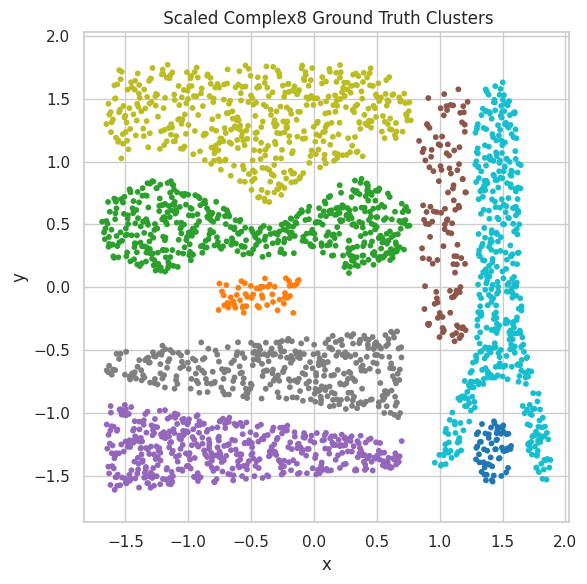

In [42]:
plt.figure(figsize=(6, 6))
plt.scatter(df_complex8_scaled['x'], df_complex8_scaled['y'], c=df_complex8_scaled['label'], cmap='tab10', s=10)
plt.title(" Scaled Complex8 Ground Truth Clusters")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis("equal")  
plt.tight_layout()
plt.show()

In [43]:

dummy_student_columns = [col for col in df_student_encoded.columns if '_' in col]
print("Dummy columns (student):", len(dummy_student_columns))
detect_zscore_outliers(df_student_scaled.drop(columns=dummy_student_columns, errors='ignore'))



Dummy columns (student): 26


,Feature,Outlier_Count,Outlier_%
0,failures,16,4.050633
1,Dalc,9,2.278481
2,famrel,8,2.025316
3,traveltime,8,2.025316
4,absences,6,1.518987
5,age,2,0.506329
6,studytime,0,0.000000
7,Fedu,0,0.000000
8,Medu,0,0.000000
9,freetime,0,0.000000


In [44]:
detect_zscore_outliers(df_wine_scaled[df_wine_scaled.select_dtypes(include=['float64', 'int64']).columns])

,Feature,Outlier_Count,Outlier_%
0,chlorides,31,1.938712
1,residual sugar,30,1.876173
2,sulphates,27,1.688555
3,free sulfur dioxide,22,1.375860
4,density,18,1.125704
5,total sulfur dioxide,15,0.938086
6,fixed acidity,12,0.750469
7,volatile acidity,10,0.625391
8,pH,8,0.500313
9,alcohol,8,0.500313


In [45]:
detect_zscore_outliers(df_complex8_scaled[df_complex8_scaled.select_dtypes(include=['float64', 'int64']).columns])




,Feature,Outlier_Count,Outlier_%
0,x,0,0.0
1,y,0,0.0
2,label,0,0.0


In [46]:
loadings_student, top_feats_student = pca_compactness_summary(df_student_scaled)
loadings_wine, top_feats_wine = pca_compactness_summary(df_wine_scaled)
loadings_spatial, top_feats_spatial = pca_compactness_summary(df_complex8)
loadings_spatial, top_feats_spatial = pca_compactness_summary(df_complex8_scaled)



Explained Variance (first 5 components):
PC1: 0.0876
PC2: 0.0661
PC3: 0.0531
PC4: 0.0453
PC5: 0.0425
Explained Variance (first 5 components):
PC1: 0.2817
PC2: 0.1751
PC3: 0.1410
PC4: 0.1103
PC5: 0.0872
Explained Variance (first 5 components):
PC1: 0.7423
PC2: 0.2576
PC3: 0.0001
Explained Variance (first 5 components):
PC1: 0.4990
PC2: 0.3313
PC3: 0.1697


In [55]:
print_top_pca_features(df_student_scaled, "Student")
print_top_pca_features(df_wine_scaled, "Wine")



=== Top 3 Feature Contributions – Student ===

PC1:
  Medu: 0.3527
  Fedu: 0.3198
  failures: 0.2800

PC2:
  Dalc: 0.3832
  Walc: 0.3723
  sex_M: 0.2978
=== Top 3 Feature Contributions – Wine ===

PC1:
  fixed acidity: 0.4893
  citric acid: 0.4636
  pH: 0.4385

PC2:
  total sulfur dioxide: 0.5695
  free sulfur dioxide: 0.5136
  alcohol: 0.3862


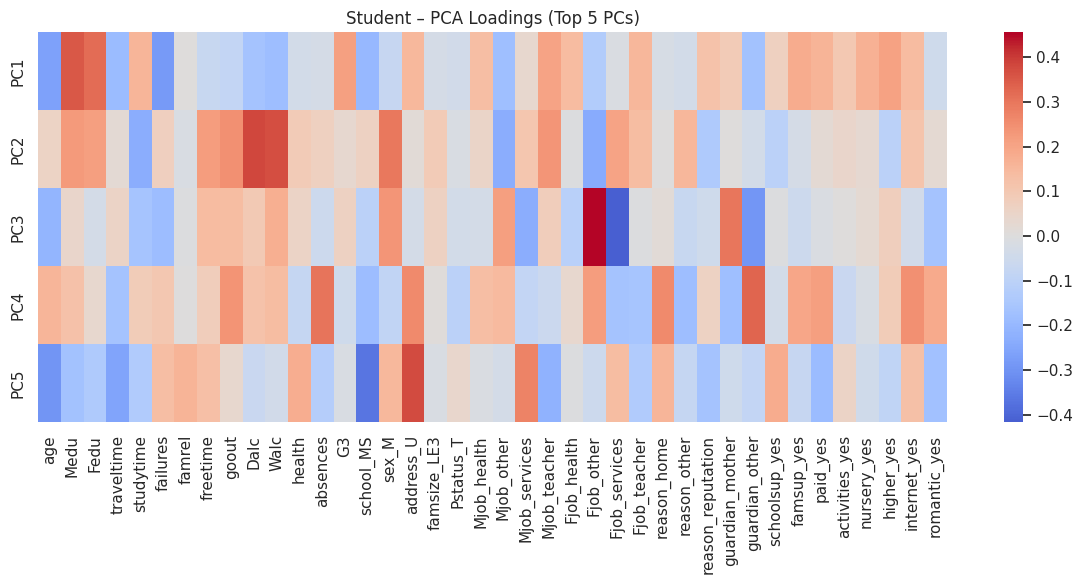

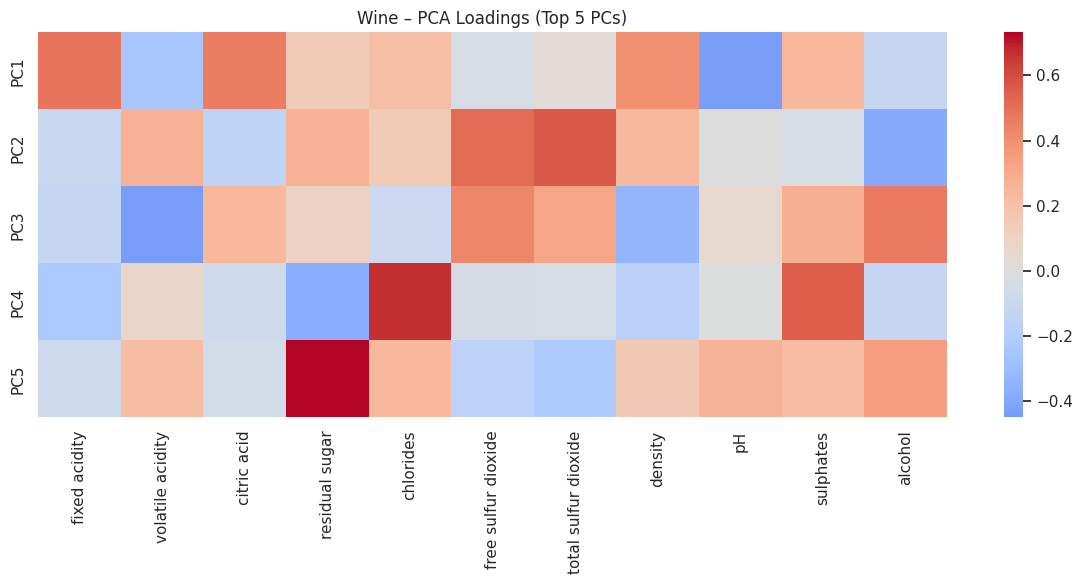

In [48]:
plot_pca_heatmap(df_student_scaled, "Student")
plot_pca_heatmap(df_wine_scaled, "Wine")


In [49]:
hopkins(df_student_scaled)



np.float64(0.606)

In [50]:

hopkins(df_wine_scaled)

np.float64(0.9189)

In [51]:
hopkins(df_complex8_scaled)


np.float64(0.9531)

In [52]:

df_student_scaled.to_csv("student_output.csv", index=False)
df_wine_scaled.to_csv("wine_output.csv", index=False)
df_complex8_scaled.to_csv("spatial_output.csv",index=False)